#### Boiler Plate

In [36]:
import random
import cv2 as cv
import networkx as nx
import numpy as np
import timeit
import datetime

from noise import pnoise2, snoise2
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy import interpolate
startTime = datetime.datetime.now()

### Global Parameters Of The Process

In [37]:
Ps = 0.7 ## probability of symetric branch
Pa = 0.1 ## probability of asymetric branch
Pc = 1-(Ps+Pa) ## probability of continium ( growth)
inputDomain='island5.png'
globalseed=4312
N_majorRivers=6
zeta = 20 # elevation range to include in candidate node selection
edgeLength = 40
eta = .75
sigma = .75
##initializations of nonparameter global variables

nodecounter = 0;
nodes=[]
candidates=[]
G = nx.DiGraph()
mouthnodes=[]
Gkd=None

#### Load Base Image 

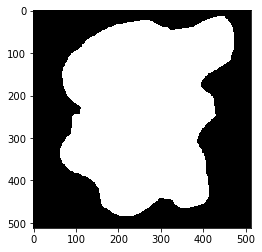

In [38]:
imgorg=cv.imread(inputDomain)
img  = imgorg.copy()
plt.imshow(img)
random.seed(globalseed)

#### Find contour of the ROI, This will be Gamma

In [39]:
imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
cv.drawContours(img, contours, -1, (0,255,0), 2)
test = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)

In [40]:
contour = contours[0]
contour=contour.reshape(-1,2)
contour=np.flip(contour,1)

#### Select first point at a ranndom offset, try to select the following points such as that the highest probability ( on a nomal distribution) is that they are furthest away from each other 


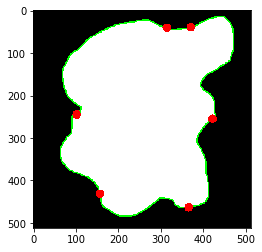

In [41]:
points = []
random.seed(globalseed)
idx = random.randint(0,len(contour)-1)
points.append(contour[idx])
N=N_majorRivers
dist = len(contours[0])/N
for i in range(1,N):
    newIdx = int((idx+i*dist+random.gauss(0, dist/6))%len(contours[0]))
    points.append(contour[newIdx])
    img2 = img.copy()
for i in range(len(points)):
    cv.circle(img2,tuple(np.flip(points[i])), 10, (255,0,0),-1)
plt.imshow(img2)

# Network Generation

In [42]:

# Borrowed , all of it
def segments_distance(a,b,c,d):
  """ distance between two segments in the plane:
      one segment is a to b
      the other is   c to d
  """
  #print(a[0],a[1],b[0],b[1],c[0],c[1],d[1],d[0])
  #print(segments_distance_internal(a[0],a[1],b[0],b[1],c[0],c[1],d[1],d[0]))
  return segments_distance_internal(a[0],a[1],b[0],b[1],c[0],c[1],d[0],d[1])

def segments_distance_internal(x11, y11, x12, y12, x21, y21, x22, y22):
  """ distance between two segments in the plane:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
  """
  if segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22): return 0
  # try each of the 4 vertices w/the other segment
  distances = []
  distances.append(point_segment_distance(x11, y11, x21, y21, x22, y22))
  distances.append(point_segment_distance(x12, y12, x21, y21, x22, y22))
  distances.append(point_segment_distance(x21, y21, x11, y11, x12, y12))
  distances.append(point_segment_distance(x22, y22, x11, y11, x12, y12))
  return min(distances)

def segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22):
  """ whether two segments in the plane intersect:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
  """
  dx1 = x12 - x11
  dy1 = y12 - y11
  dx2 = x22 - x21
  dy2 = y22 - y21
  delta = dx2 * dy1 - dy2 * dx1
  if delta == 0: return False  # parallel segments
  s = (dx1 * (y21 - y11) + dy1 * (x11 - x21)) / delta
  t = (dx2 * (y11 - y21) + dy2 * (x21 - x11)) / (-delta)
  return (0 <= s <= 1) and (0 <= t <= 1)

import math
def point_segment_distance(px, py, x1, y1, x2, y2):
  dx = x2 - x1
  dy = y2 - y1
  if dx == dy == 0:  # the segment's just a point
    return math.hypot(px - x1, py - y1)

  # Calculate the t that minimizes the distance.
  t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

  # See if this represents one of the segment's
  # end points or a point in the middle.
  if t < 0:
    dx = px - x1
    dy = py - y1
  elif t > 1:
    dx = px - x2
    dy = py - y2
  else:
    near_x = x1 + t * dx
    near_y = y1 + t * dy
    dx = px - near_x
    dy = py - near_y

  return math.hypot(dx, dy)

def point_segment_distance_tuple(p,a,b):
        return point_segment_distance(p[0],p[1],a[0],a[1],b[0],b[1])
    
def segments_intersect_tuple(a1,a2,b1,b2):
    return segments_intersect(a1[0],a1[1],a2[0],a2[1],b1[0],b1[1],b2[0],b2[1])

    

In [43]:
def addNode(pointInspace,Priority):
    global nodecounter
    global nodes
    global candidates
    global G
    global Gkd
    nodes.append(nodecounter)
    candidates.append(nodecounter)
    G.add_node(nodecounter,pos=(pointInspace[0],pointInspace[1]),elevation=pointInspace[2],priority=Priority,rosgen='',flow=0) ## XYZ of initial node, on the border, should be at some threshold above sea level
    nodecounter+=1
    allpoints_list = [[G.nodes[x]['pos'][0],G.nodes[x]['pos'][1]] for x in nodes]
    allpoints_nd = np.array(allpoints_list)
    Gkd = cKDTree(allpoints_nd)

In [44]:

## make rivermouths into nodes and add them to candidates for expansion
for i in range(len(points)):
    mouthnodes.append(nodecounter)
    addNode((points[i][1],points[i][0],0),1)
    


In [45]:
def selectNode(candidate_nodes,zeta):
#    lowestCandidateZ = 99999
    lowestCandidateZ = min([G.nodes[i]['elevation'] for i in candidate_nodes])
#    for i in range(len(candidate_nodes)):
#        z=G.nodes[candidate_nodes[i]]['elevation']
#        lowestCandidateZ = min(z,lowestCandidateZ);
    subselection = [n for n in candidate_nodes if G.nodes[n]['elevation'] < lowestCandidateZ+zeta ]
#    for node in candidate_nodes:
#            z=G.nodes[node]['elevation']
#            if z < lowestCandidateZ+zeta:
#               subselection.append(node)

    subselection.sort(key = lambda r : G.nodes[r]['priority'],reverse = True)
    subsubselection=[i for i in subselection if G.nodes[i]['priority'] == G.nodes[subselection[0]]['priority']]
#    for i in range(len(subselection)):
#        if G.nodes[subselection[i]]['priority'] == G.nodes[subselection[0]]['priority']:
#            subsubselection.append(subselection[i])
    idxOfLowestCandidateZ =[G.nodes[i]['elevation'] for i in subsubselection].index(min([G.nodes[i]['elevation'] for i in subsubselection])) 
    
    return subsubselection[0]


In [46]:
def alpha(priority,node):
    if priority==1:
        ruleBase(priority,node)
    else:
        Pval = random.random();
        if Pval <= Pa:
            rulePa(priority,node)
        elif Pval <= Pa+Pc:
            rulePc(priority,node)
        else:
            rulePs(priority,node)

            
def ruleBase(priority,node): #filling
    #tao(priority,node)
    for i in range(random.randint(1,5)):
        beta(priority,node)
        
        
def rulePc(priority,node): #rive growth
    #tao(priority,node)
    beta(priority,node)
    
    
def rulePs(priority,node): #symetric junction
    #tao(priority,node)
    beta(priority-1,node)
    beta(priority-1,node)

    
def rulePa(priority,node): # asymetric junction
    #tao(priority,node)
    beta(priority,node)
    beta(random.randint(1,priority-1),node)
    
    
def beta(priority,node):
    possiblenewones = picknewnodepos(node)
    if len(possiblenewones)>0:
        point = possiblenewones[random.randint(0,len(possiblenewones)-1)]# random.sample(possiblenewones,1)
        newZ = G.nodes[node]['elevation']+random.randint(1,zeta) #TODO river slope map
        addNode((point[1],point[0],newZ),priority)
        G.add_edge(node,nodes[-1]) ## XYZ of initial node, on the border, should be at some threshold above sea level
    else:
        tao(priority,node)


def tao(priority,node):
    try:
        candidates.remove(node)
    except:
        None
    finally:
        None
        
        
def picknewnodepos(parentnode):
    s= datetime.datetime.now()
    
    pos = [G.nodes[parentnode]['pos'][1],G.nodes[parentnode]['pos'][0]]
    sx=max(0,pos[0]-edgeLength)
    sy=max(0,pos[1]-edgeLength)
    sub = imgray[sx:min(imgray.shape[0],pos[0]+edgeLength),sy:min(imgray.shape[1],pos[1]+edgeLength)]
    domain = np.argwhere(sub>0) # pixels relative to pos-(sx,sy)
    withinEdistance  = np.floor(np.linalg.norm(domain+(sx-pos[0],sy-pos[1]),axis=1))==edgeLength
    
    atEdistanceFromNode = domain[withinEdistance]
    awayfromGamma=[]
    a=datetime.datetime.now()
    print("pa:",a-s)
    for p in atEdistanceFromNode:
        aa=p+(sx,sy)
        dist_gamma =cv.pointPolygonTest(contour,(aa[0],aa[1]),True)
        if abs(dist_gamma)>eta*edgeLength:
            awayfromGamma.append((aa[0],aa[1]))
    edgeCleared = awayfromGamma.copy()
    b=datetime.datetime.now()
    print("pb:",b-a)
    for i in range(len(awayfromGamma)):
        p = awayfromGamma[i]
        nodesToCheck=Gkd.query_ball_point((p[1],p[0]),2*edgeLength)
        myedges=[G.out_edges(n) for n in nodesToCheck]
        myedges = [item for edges in myedges for item in edges]
        
        for j in range(len(myedges)):
                e= myedges[j]
                dist = point_segment_distance(p[1],p[0],G.nodes[e[0]]['pos'][0],G.nodes[e[0]]['pos'][1],G.nodes[e[1]]['pos'][0],G.nodes[e[1]]['pos'][1])
                if dist<edgeLength*sigma:
                    l1 = len(edgeCleared)
                    edgeCleared.remove(p)
                    assert(len(edgeCleared)<l1)
                    break
    c=datetime.datetime.now()
    print("pc:",c-b)
    return edgeCleared

In [47]:
nodesToCheck=[0,1]
myedges=[e for e in [G.out_edges(n) for n in nodesToCheck]]
print(nodesToCheck)

[0, 1]


In [48]:
def calculateHorton_Strahler(selectedCandidate):
    #find the leafs from this node and calculate upstream
    leafs = [s for s in nx.descendants(G,selectedCandidate) if len(G.out_edges(s))==0]
    workingqueue=leafs
    nextQueue=set()
    while len(workingqueue)>0:
        nextQueue=set()
        for i in range(len(workingqueue)):
            priority=1
            children = G.successors(workingqueue[i])
            ChildrenPriorities = [G.nodes[x]['priority'] for x in children]
            if len(ChildrenPriorities)>0:
                priority = max(ChildrenPriorities)
                if ChildrenPriorities.count(priority)>1:
                    priority=priority+1
            G.nodes[workingqueue[i]]['priority']=priority;
            parent = G.predecessors(workingqueue[i])
            parent=[x for x in parent]
            if len(parent)==1:
                nextQueue.add(parent[0])
        workingqueue=list(nextQueue)    


def calculateHorton_Strahler_():
    leafs = [x for x in G.nodes() if G.out_degree(x)==0]
    workingqueue=leafs
    nextQueue=set()
    while len(workingqueue)>0:
        nextQueue=set()
        for i in range(len(workingqueue)):
            priority=1
            children = G.successors(workingqueue[i])
            ChildrenPriorities = [G.nodes[x]['priority'] for x in children]
            if len(ChildrenPriorities)>0:
                priority = max(ChildrenPriorities)
                if ChildrenPriorities.count(priority)>1:
                    priority=priority+1
            G.nodes[workingqueue[i]]['priority']=priority;
            parent = G.predecessors(workingqueue[i])
            parent=[x for x in parent]
            if len(parent)==1:
                nextQueue.add(parent[0])
        workingqueue=list(nextQueue)


In [49]:
from IPython.display import clear_output, display
while len(candidates)!=0:
    s= datetime.datetime.now()
    selectedCandidate = selectNode(candidates,zeta)
    a=datetime.datetime.now()
    alpha(G.nodes[selectedCandidate]['priority'],selectedCandidate)
    b=datetime.datetime.now()
    calculateHorton_Strahler(selectedCandidate)
    c=datetime.datetime.now()
    clear_output(wait=True)
    print("A:",a-s)
    print("B:",b-a)
    print("C:",c-b)
    print(len(nodes))  # use display(f) if you encounter performance issues
 


A: 0:00:00
B: 0:00:01.114239
C: 0:00:00
79


In [50]:
nodesToCheck=Gkd.query_ball_point(G.nodes[0]['pos'],2*edgeLength)
myedges=[G.out_edges(n) for n in nodesToCheck]
myedges = [item for edges in myedges for item in edges]
print(nodesToCheck)
print(myedges)

[14, 6, 0, 16]
[(14, 51), (6, 14), (6, 15), (6, 16), (0, 6), (16, 65)]


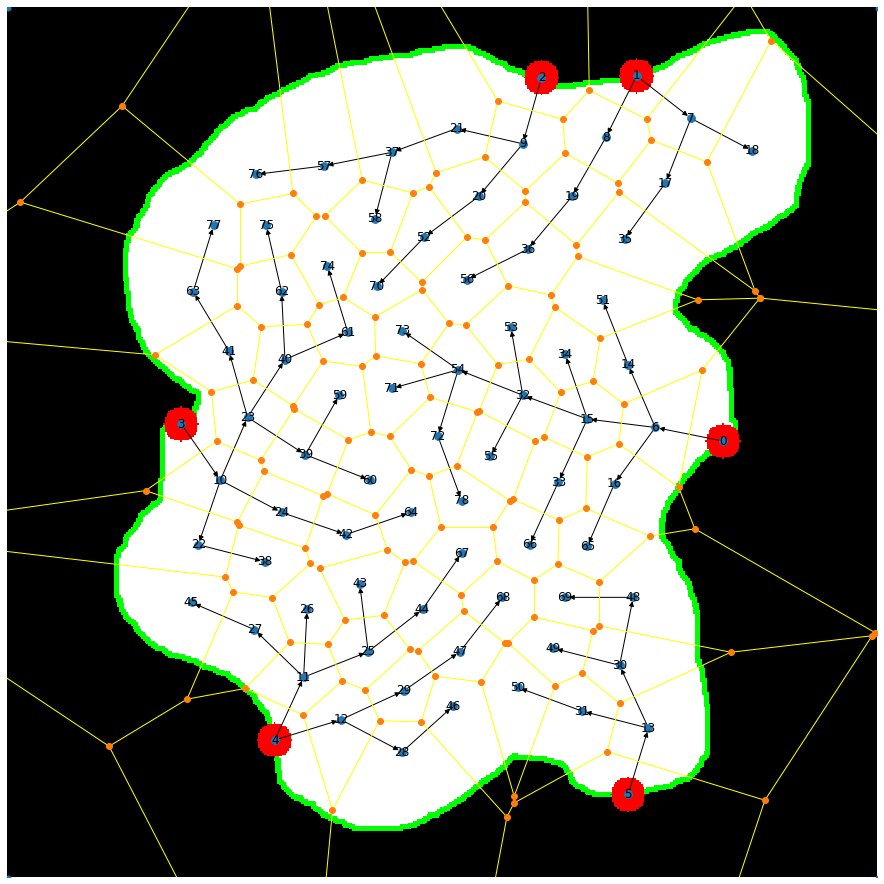

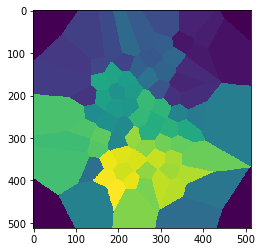

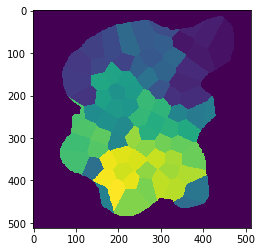

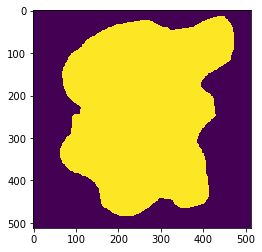

In [51]:
imgvoronoi = np.zeros(imgray.shape,dtype=np.uint16)
from scipy.spatial import Voronoi, voronoi_plot_2d
points=[G.nodes[x]['pos'] for x in nodes]
points.append((0,0))
points.append((0,img2.shape[1]))
points.append((img2.shape[0],0))
points.append((img2.shape[0],img2.shape[1]))

vor = Voronoi(points,qhull_options="Qbb Qc Qz Qx")

pos=nx.get_node_attributes(G,'pos')
#labels = list(map(lambda x: G.nodes[x]['priority'],nodes))
labels = list(map(lambda x: x,nodes))
labels = dict(zip(nodes,labels))
#nx.draw_networkx_labels(G,pos)
'''
fig=voronoi_plot_2d(vor,line_colors='red')
fig.set_size_inches(16, 16, forward=True)
fig.set_dpi(80)
plt.imshow(img2,aspect='auto')
fig.set_tight_layour(True)
'''
ret, thresh = cv.threshold(imgray, 127, 1, 0)
mask = np.array(thresh, dtype=np.uint16)
mask*=(256*256-1)
voroniCount=1
for n in nodes:
    ridx=vor.point_region[n]
    if ridx==-1:
        continue
    r = vor.regions[ridx]
    debp = [vor.vertices[x].astype(int) for x in r if x!=-1]
    debp = np.array([[x[0],x[1]] for x in debp])
    cv.fillPoly(imgvoronoi,[debp],np.int16(ridx+1).item())
    voroniCount+=1

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.imshow(img2)
ylim=ax.get_ylim();
xlim=ax.get_xlim();
nx.draw(G,pos,node_size=60,labels=labels,ax=ax)
voronoi_plot_2d(vor, point_size=10, ax=ax,line_colors=['yellow'])
ax.set_ylim(ylim);
ax.set_xlim(xlim);
kernel = cv.getStructuringElement(cv.MORPH_RECT,(2,2))
plt.show()
plt.imshow(imgvoronoi)
imgvoronoi = cv.bitwise_and(imgvoronoi,mask)

plt.show()
plt.imshow(imgvoronoi)
plt.show()
plt.imshow(mask)



In [52]:
np.unique(imgvoronoi)

array([ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84], dtype=uint16)

### voronoiimg has the watersheds where pixels of value  centernodeidx + 1 are pixels that belong to watershed of node centernodeidx, since there is only one s for each node ( that is the incoming edge from the parent ), we can calculate the watershed areas and store them into each node

In [53]:
for node in nodes:
    pos = G.nodes[node]['pos']
    pixelVal = imgvoronoi[pos[1]][pos[0]]
    area = np.count_nonzero(imgvoronoi==pixelVal)
    G.nodes[node]['localwatershedarea']=area

    

In [54]:
for node in nx.dfs_postorder_nodes(G):
    localWatershed = G.nodes[node]['localwatershedarea']
    Watershed =localWatershed+ sum([G.nodes[src]['inheritedwatershed'] for src in G.successors(node)])
    G.nodes[node]['inheritedwatershed']=Watershed
    G.nodes[node]['flow'] =0.42*G.nodes[node]['inheritedwatershed']**0.69


In [55]:
#### Voronoi vertex v1,v2 accesses pixelvalue of img at [v2,v1]
# calcualte Zs of Qs, for each q its the max of the input nodes that has q in its region, plus a random margin

qz={}
qd={}
for n in nodes:
    r=vor.point_region[n]
    if r==-1:
        continue
    for vertex in vor.regions[r]:
        #print(n,r,vertex,vor.vertices[vertex])
        if  not(0<=  int(vor.vertices[vertex][0]) < imgray.shape[0] and 0<=  int(vor.vertices[vertex][1]) < imgray.shape[1]):
            continue ## ignore vertices outside of the image
        #print(vertex)
        if vertex not in qz:
            qz[vertex]=0
            qd[vertex] = int(np.linalg.norm( vor.vertices[vertex].astype(int) - G.nodes[n]['pos']))
            #print('added')
            #print(qd[vertex])
        qz[vertex]= max(qz[vertex],G.nodes[n]['elevation'])
    qs = [vor.vertices[x].astype(int) for x in vor.regions[n] if x!=-1]
    

In [56]:
for q in qz:
    qz[q]+= int((random.uniform(0,.25) *qd[q]) ) # TODO terrain slope map
    #qz[q]+=5

In [57]:
#qvals = [imgray[int(vertex[1]),int(vertex[0])] for vertex in vor.vertices if  0<=  vertex[0] < imgray.shape[0] and 0<=  vertex[1] < imgray.shape[1]]

In [58]:
def classify(Node):
    # Based on river slope and distance from Gamma
    # TODO: A real classification
    es = G.out_edges(Node)
    es = list(es)
    for e in es:
        grade=(G.nodes[e[1]]['elevation']-G.nodes[e[0]]['elevation'])/edgeLength
        if grade > 0.1:
            G.nodes[e[1]]['rosgen']='A+'
        elif grade >0.04:
            G.nodes[e[1]]['rosgen']='A'
        elif grade > 0.02:
            G.nodes[e[1]]['rosgen']=['G','D','B'][random.randint(0,2)];
        elif grade > 0.005:
            G.nodes[e[1]]['rosgen']=['C','D','E','F'][random.randint(0,3)];
        else :
            G.nodes[e[1]]['rosgen']='DA'
            
from itertools import islice

def window(seq, n=2): ##Borrowed as is
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
def clean_asin(sinAngle): ## Borrowed but modified
    return math.asin(min(1,max(sinAngle,-1)))

In [59]:
for n in nodes:
    classify(n)

In [60]:

#Create confluences, to do that, sort the outgoing edges(these are the inlets to the node) by the angle they form with the node
import math
for n in nodes:
    es = G.out_edges(n)
    ie = G.in_edges(n)
    if len(list(ie))==0:
        continue
    assert( (len(list(ie))==1 ))
    ie = list(ie)[0]
    vRef = np.subtract(G.nodes[ie[1]]['pos'],G.nodes[ie[0]]['pos'])
    vRef = vRef / np.linalg.norm(vRef)
    es = list(es);
    
    es.sort(key = lambda r : clean_asin((np.cross(np.subtract(G.nodes[r[1]]['pos'],G.nodes[r[0]]['pos'])/np.linalg.norm(np.subtract(G.nodes[r[1]]['pos'],G.nodes[r[0]]['pos'])),vRef))),reverse = True)
    # es now contains edges sorted by the angle they form with the source vector    
    wes = window(es)
    #print(es)
    #for upstream in wes:
        # create junctions
    #    print(upstream[0],upstream[1])
    ks=[]
    for e in wes:
        angle = random.uniform(0,10)
        if G.nodes[e[0][1]]['priority']!=G.nodes[e[1][1]]['priority']:
            angle+=80
        ks+=[angle]
    
    lastconfluence=None
    if len(ks)==0:
        # connect the only upstream node to the outlet
        None
    else:
        # create confluence between memebers of ks, then connect last confluence to outlet
        None

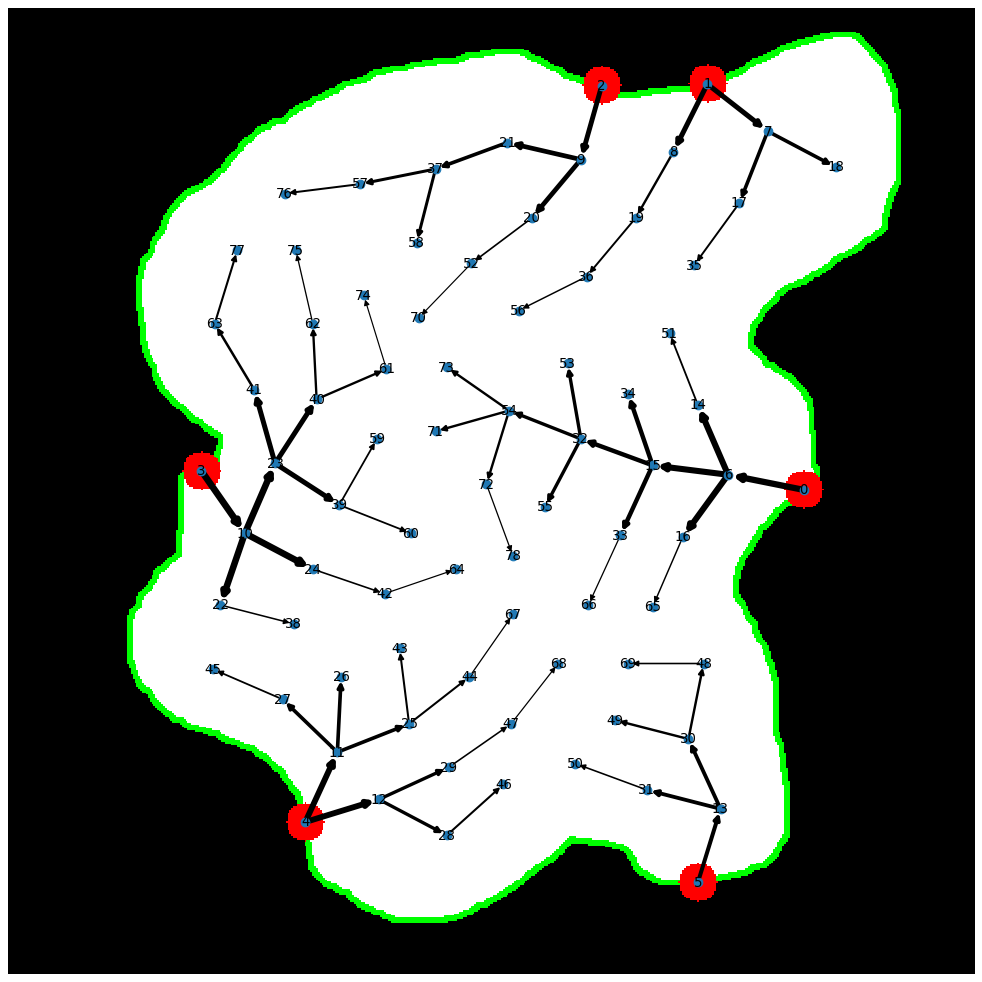

In [61]:
plt.figure(num=None, figsize=(16, 16), dpi=80)
pos=nx.get_node_attributes(G,'pos')
plt.imshow(img2)
#labels = list(map(lambda x: G.nodes[x]['priority'],nodes))
labels = list(map(lambda x: x,nodes))
labels = dict(zip(nodes,labels))
#nx.draw_networkx_labels(G,pos)
normalizer =max([G.nodes[u]['flow'] for u in nodes]) 
weights = [6*G.nodes[u]['flow']/normalizer for u,v in G.edges]

nx.draw(G,pos,node_size=60,labels=labels,width=weights)


In [62]:
def distance(a,b):
   return np.linalg.norm( np.subtract(a , b))


In [63]:
maxNodeElevation = max([G.nodes[n]['elevation'] for n in nodes])
maxqElevation = max(qz.values())
maxZ = max([maxNodeElevation,maxqElevation])


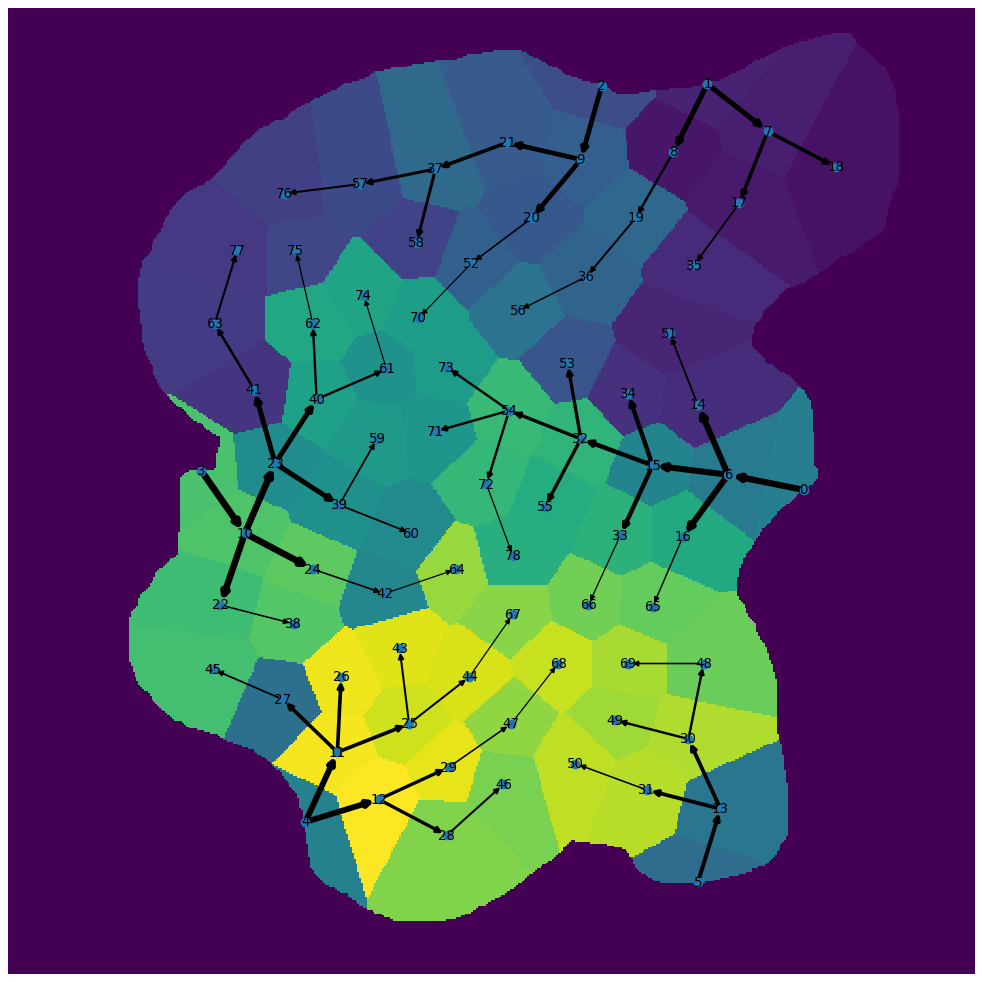

In [64]:
plt.figure(num=None, figsize=(16, 16), dpi=80)
pos=nx.get_node_attributes(G,'pos')
plt.imshow(imgvoronoi)
labels = list(map(lambda x: x,nodes))
labels = dict(zip(nodes,labels))
normalizer =max([G.nodes[u]['flow'] for u in nodes]) 
weights = [6*G.nodes[u]['flow']/normalizer for u,v in G.edges]

nx.draw(G,pos,node_size=60,labels=labels,width=weights)

In [65]:
#Borrowed, heavily modified
from poisson import PoissonGenerator

disk = False                # this parameter defines if we look for Poisson-like distribution on a disk/sphere (center at 0, radius 1) or in a square/box (0-1 on x and y)
repeatPattern = True        # this parameter defines if we look for "repeating" pattern so if we should maximize distances also with pattern repetitions
num_points = 50              # number of points we are looking for
num_iterations = 4          # number of iterations in which we take average minimum squared distances between points and try to maximize them
first_point_zero = disk     # should be first point zero (useful if we already have such sample) or random
iterations_per_point = 128  # iterations per point trying to look for a new point with larger distance
sorting_buckets = 0         # if this option is > 0, then sequence will be optimized for tiled cache locality in n x n tiles (x followed by y)
num_dim = 2                 # 1, 2, 3 dimensional version
num_rotations = 1           # number of rotations of pattern to check against

allteepoints = []
taos_for_regions = {}
poisson_generator = PoissonGenerator( repeatPattern, first_point_zero)
points = poisson_generator.find_point_set(num_points, num_iterations, iterations_per_point, num_rotations)
for n in nodes:
    r = vor.regions[vor.point_region[n]]
    ridge_positions = { x:(vor.vertices[x].astype(int)[0],vor.vertices[x].astype(int)[1]) for x in r if x!=-1 }
    reg = list(ridge_positions.values())
    rreg = [[x[0],x[1]] for x in reg]
    rreg= np.array(rreg)
    idxes = np.where(imgvoronoi==vor.point_region[n]+1)
    xllim = min(x for x in idxes[0])
    xulim = max(x for x in idxes[0])
    yllim = min(x for x in idxes[1])
    yulim = max(x for x in idxes[1])
    b= np.array([[xllim,yllim],[xllim,yulim],[xulim,yllim],[xulim,yulim]])
    b=cv.minAreaRect(b)
    pts = cv.boxPoints(b)
    
    xllim = int(min(x[0] for x in pts))
    xulim = int(max(x[0] for x in pts))
    yllim = int(min(x[1] for x in pts))
    yulim = int(max(x[1] for x in pts))
    

    points_projected = [ [int(p[0]*(yulim-yllim)+yllim),int(p[1]*(xulim-xllim)+xllim)] for p in points]
    points_filtered = [ (p[0],p[1]) for p in points_projected if imgvoronoi[p[1]][p[0]]==vor.point_region[n]+1 ]
    allteepoints+=points_filtered
    taos_for_regions[vor.point_region[n]]=points_filtered
    clear_output(wait=True)
    print(n," out of ",len(nodes))  # use display(f) if you encounter performance issues

78  out of  79


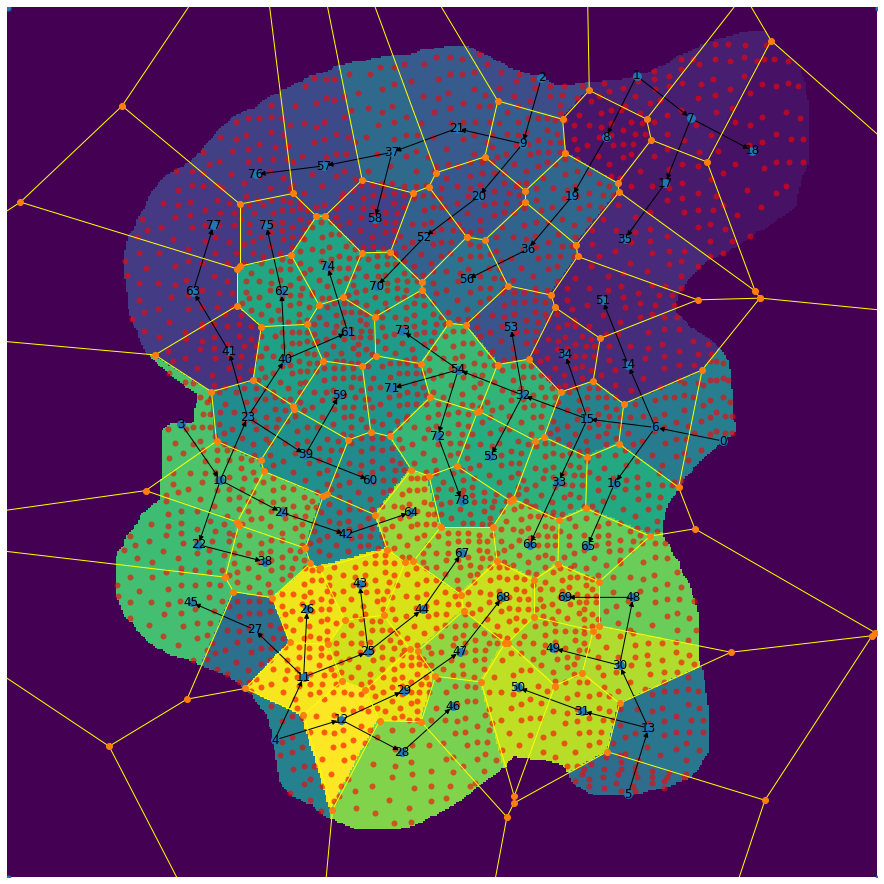

In [66]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(111)
ax.imshow(imgvoronoi)
ax.scatter(*zip(*allteepoints), color='r', alpha=0.6, lw=0)

ylim=ax.get_ylim();
xlim=ax.get_xlim();
nx.draw(G,pos,node_size=60,labels=labels,ax=ax)
voronoi_plot_2d(vor, point_size=10, ax=ax,line_colors=['yellow'])

ax.set_ylim(ylim);
ax.set_xlim(xlim);
plt.show()


In [67]:
def projection(p,u,v):
    n = np.subtract(u,v)
    nnorm = np.linalg.norm(n, 2)
    n = n/nnorm
    ret = np.dot(np.subtract(p,v), n)
    proj = ret/nnorm
    if proj >1 :
        proj=1
    if proj <0 :
        proj =0
    return proj*n

In [68]:
import shapely.geometry as geom
import numpy as np
from shapely.geometry import asLineString

point = geom.Point(0.8, 10.5)

# Note that "line.distance(point)" would be identical
rivers = {}
for n in mouthnodes:
    leaves = [s for s in nx.descendants(G,n) if len(G.out_edges(s))==0]
    for leaf in leaves:
        path = nx.shortest_path(G,n,leaf)
        x = np.array([G.nodes[p]['pos'][0] for p in path])
        y = np.array([G.nodes[p]['pos'][1] for p in path])
        z = np.array([G.nodes[p]['elevation'] for p in path])
        if len(x)<4:
            x1 = (x[0]+x[1])/2
            x2 = (x[0]+x1)/2
            y1 = (y[0]+y[1])/2
            y2 = (y[0]+y1)/2
            z1 = (z[0]+z[1])/2
            z2 = (z[0]+z1)/2
            tmp = x[1:]
            x = [x[0],x2,x1]+list(tmp)
            x = np.array(x)
            tmp=y[1:]
            y = [y[0],y2,y1]+list(tmp)
            y = np.array(y)
            tmp=z[1:]
            z = [z[0],z2,z1]+list(tmp)
            z = np.array(z)
        
        tck, u = interpolate.splprep([x, y,z], s=0)
        unew = np.arange(0, 1.01, 0.05)
        out = interpolate.splev(unew, tck)
        lstr=[]
        dbg=[]
        for i in range(len(out[0])):
            lstr.append((out[0][i],out[1][i],int(out[2][i])))
            dbg.append(int(out[2][i]))
        line = asLineString(lstr)
        for p in path:
            if p in rivers:
                rivers[p].append(line)
            else:
                rivers[p]=[line]

In [69]:
print(dbg)

[0, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 6, 7, 8, 10, 13, 16, 19, 24]


In [70]:
# TODO:Calculate Zees for Cees of Tees ( Elevations of center points of terrain primitives)
# 
rwidth=6    

czs = {}
for t in allteepoints:
    i = t[1]
    j = t[0]
    ridx = imgvoronoi[i][j]-1
    r = vor.regions[ridx]
    ridge_positions = { x:(vor.vertices[x].astype(int)[0],vor.vertices[x].astype(int)[1]) for x in r if x!=-1 and 0<=  vor.vertices[x].astype(int)[0] < imgray.shape[0] and 0<=  vor.vertices[x].astype(int)[1] < imgray.shape[1]}
    #ridge_positions = np.array([[x[0],x[1]] for x in verts_in_r if 0<=  x[0] < imgray.shape[0] and 0<=  x[1] < imgray.shape[1]]) 
    ridge_elevations = { x:qz[x] for x in r if x  in qz }
    r_refined = list(ridge_positions.keys())
    #find closest ridge point
    closestR =r_refined[[distance((j,i),ridge_positions[x]) for x in r_refined].index(min([distance((j,i),ridge_positions[x]) for x in r_refined]))]
    elevationAtClosestR = ridge_elevations[closestR]
    dist_gamma =cv.pointPolygonTest(contour,(i,j),True)
    distanceFromR = distance((j,i),ridge_positions[closestR])
    if(dist_gamma<distanceFromR):
        distanceFromR = dist_gamma
        elevationAtClosestR=10
    #point.distance(rivers[n])
    point = geom.Point(j,i)
    nodeOfregion = list(vor.point_region).index(ridx)
    local_rivers = rivers[nodeOfregion]
    #print(local_rivers)
    rividx = [point.distance(x) for x in local_rivers].index(min([point.distance(x) for x in local_rivers]))
    projected = local_rivers[rividx].interpolate(local_rivers[rividx].project(point))
    distancefromN = point.distance(local_rivers[rividx])
    if distancefromN==0 and distanceFromR==0:
        distancefromN=1
    lerpedelevation = projected.z*(distanceFromR/(distanceFromR+distancefromN))+elevationAtClosestR*(distancefromN/(distanceFromR+distancefromN))
    fixed = int(lerpedelevation)
    clear_output(wait=True)
    print(len(czs)," out of ",len(allteepoints))  # use display(f) if you encounter performance issues

    # find edges of node to which j,i are closest
    #es = list(G.out_edges(n))+list(G.in_edges(n))
    #closestEdge = [point_segment_distance_tuple((j,i),G.nodes[e[0]]['pos'], G.nodes[e[1]]['pos']) for e in es].index(min([point_segment_distance_tuple(j,i),G.nodes[e[0]]['pos'], G.nodes[e[1]]['pos']) for e in es]))
    czs[t]=fixed
czsall = [czs[t] for t in allteepoints]
allpoints_list = [[x[0],x[1]] for x in allteepoints]
allpoints_nd = np.array(allteepoints)
apkd = cKDTree(allpoints_nd)

discard = imgray.copy()
radius = 0
while np.where(discard==255)[0].shape[0] >0:
    radius+=1;
    for tao in allteepoints:
        cv.circle(discard,tao, radius, (0,0,0),-1)



2479  out of  2480


In [71]:
def TerrainFunction(point):
    if imgray[point[1]][point[0]]==0:
        return 0
    #a =  datetime.datetime.now()
    ts = apkd.query_ball_point(point,radius) # within r distance of point
    #b =  datetime.datetime.now()
    #print("1:",b-a)
    #rs = setOfRivers # within r distance of point
    wts = [w(distance(point,allteepoints[t])) for t in ts]
    hts = [ht(point,allteepoints[t]) for t in ts]
    #ht_ = height_b(hts,wts)
    #wt_ = np.sum(wts)/max(len(wts),1)
    #hr_ = height_b(hrs,wrs)
    #c =  datetime.datetime.now()
    #print("2:",c-b)
    ht_ = height_b(hts,wts)
    wt_ = wts[0]
    #for i in range(1,len(wts)):
    #    ht_ = (wt_*ht_+wts[i]*hts[i])/(wt_+wts[i])
    #    wt_ = (wt_+wts[i])/2
    #wr_ = np.sum(wrs)/max(len(wrs),1)
    wi=wt_
    hi=ht_
    ridx = imgvoronoi[point[1]][point[0]]-1
    if ridx==-1:
        return hi
    #d =  datetime.datetime.now()
    #print("3:",d-c)
    node = list(vor.point_region).index(ridx)
    geomp = geom.Point(point[0],point[1])
    #rs  = [e for e in G.edges(node) if point_segment_distance_tuple(point,G.nodes[e[0]]['pos'],G.nodes[e[1]]['pos']) < radius ]+[e for e in G.in_edges(node) if point_segment_distance_tuple(point,G.nodes[e[0]]['pos'],G.nodes[e[1]]['pos']) < radius ]
    #e =  datetime.datetime.now()
    #print("4:",e-d)
    rs  = [e for e in rivers[node] if geomp.distance(e) < radius ]
    #xe =  datetime.datetime.now()
    #print("4a:",xe-e)
    hrs = [hr(geomp,e) for e in rs]
    #ye =  datetime.datetime.now()
    #print("4b:",ye-xe)
    wrs = [w(geomp.distance(e)) for e in rs]
    #f =  datetime.datetime.now()
    #print("4c:",f-ye)
    #print("5:",f-e)

    for i in range(len(rs)): 
        hi=(1-wrs[i])*hi+wrs[i]*hrs[i] 
        wi = (1-wrs[i])*wi+wrs[i]**2
    #g =  datetime.datetime.now()
    #print("6:",g-f)
    if hi<0:
        print(hrs,wrs)
    return hi

def height_b(h,w):
    try:
        ret = np.sum(np.multiply(h,w))/(np.sum(w))
        assert(ret>=0)
        assert(not np.isnan(ret))
        return ret
    except:
        return 0

scale = 100.0
octaves = 6
persistence = 0.5
lacunarity = 2.0
def ht(p,t):
    return czs[t] +pnoise2(p[0]/scale,p[1]/scale,octaves=octaves,persistence=persistence,lacunarity=lacunarity,repeatx=imgray.shape[0],repeaty=imgray.shape[1],base=0)*10


def hr(p,r):
    
    d=p.distance(r)
    segma = min(rwidth**2,d**2)
    projected = r.interpolate(r.project(p))
    if projected.z<0:
        print("0")
    return projected.z+segma


def w(d):
    if d <1:
        return 1;
    return (max(0,(radius+1)-d)/((radius+1)*d))**2

start: 2019-12-16 16:25:38.382326


0
0


0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[36.53744813181218, -0.24613007120435226] [0.002351710722429959, 1]
0
[36.65213067794147, -0.7678611118818407] [0.0027610558568187888, 1]
0
[36.76681322407077, -0.7797902999118542] [0.0032367565185287745, 1]
0
[36.88149577020007, -0.6869718493454071] [0.003790646800264168, 1]
0
[37.01907119697297, -0.5394161496199217] [0.00444088731162194, 1]
0
[37.133717288805016, -0.3371232007353969] [0.005265417571926479, 1]
0
[37.24836338063706, -0.08009300269183317] [0.006246888395056095, 1]
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[36.27266292402027, 9.700878020032246, -0.4832635833985025, 40.676577034119184] [0.002867749475272811, 0.15740541719614867, 1, 0.0018456848748334268]
0
[36.38734547014957, -0.8895136244979225] [0.003360883294210131, 1]
0
[36.502028016278864, -0.9970781664343924] [0.003935375809532725, 1]
0
[36.61671056240816, -0.8059572092079121] [0.004606328460220112, 1]
0
[36.73139310853746, -0.4091429316293887] [0.005392271903648607, 1]
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[38.84597787745624, 36.0, 5.535168873382413, -0.6757485897196758, 40.23527878815255] [7.941729375150613e-05, 0.00349108627951228, 0.8053880937594082, 1, 0.003933976951008723]
0
[36.12256026235766, 8.131794795495393, -0.9665176312410276, 40.34150442986606] [0.0040855435038692255, 0.21844284983773157, 1, 0.0024138809412314597]
0
[36.237242808486954, 12.123753266961202, -0.9586011735994293, 40.44773007157957] [0.0047820133429806394, 0.09159199715964306, 1, 0.0014534855695295316]
0
[36.35192535461625, -0.6519992167948809] [0.005598483175622267, 1]
0
[36.46660790074555, -0.04671176082738249] [0.00655907505667294, 1]
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[38.53638060041263, 36.0, 37.77705900053606, 3.8900531654397703, -0.6314344895139521, 39.78280436834929] [0.00040746855047922717, 0.004367707974723117, 9.041763844242008e-05, 1, 1, 0.008338509139224522]
0
[38.58594315834112, 36.0, 4.605804005536479, -0.9985991661103283, 39.887511719918656] [0.00017998033792818098, 0.005048380165987803, 1, 1, 0.005106441018914447]
0
[38.63550571626961, 36.0, 6.725635442517268, -0.87547567489149, 39.992219071488016] [5.81352675004329e-05, 0.005837084002705599, 0.3174414430225745, 1, 0.00314017379363754]
0
[36.08714014682434, 10.240799428850885, -0.4533927185088733, 40.11265746732644] [0.006811852430750689, 0.11982382256380458, 1, 0.0019138919191480869]
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[38.2763458812975, 36.0, 37.49370958263341, 3.525934667070431, -0.8740534601078966, 37.49151776934549] [0.0006857706055045988, 0.006319644754420264, 0.00023741684127429874, 1, 1, 0.010966953037653347]
0
[38.325908439226, 36.0, 37.508473746711374, 4.153583553777033, -0.9538700783769862, 39.553085088069025] [0.00034190086046801196, 0.007316317373222757, 8.44864396887179e-05, 1, 1, 0.006658633073945079]
0
[38.37547099715449, 36.0, 5.844551685360277, -0.3846428681716152, 39.657792439638385] [0.00014333322090288923, 0.008481551189861505, 0.4179376858520395, 1, 0.004092817638962746]
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
[37.63856251039306, 36.0, 36.83912071405886, 3.165829522224466, -0.9894562043053357, 31.62388063771709] [0.0012379170605831009, 0.009199910874093643, 0.0005204581571310137, 1, 1, 0.014548671307994325]
0
[37.64211976874103, 34.56543237140008, 36.823227796243955, 3.7281524872927387, -0.7819247642471386, 39.218658456219394] [0.000664148208638217, 0.010696403860584782, 0.0002412655281728578, 1, 1, 0.008713964338458067]
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
[37.453338001817855, 32.846790849564165, 36.76001211722112, 3.3760599323485723, -0.8234783920172922, 18.13067113308791] [0.0037095626482976825, 0.011624397052339013, 0.0019168243533844152, 1, 1, 0.035223250331543235]
0
[37.45689526016582, 29.808744337358203, 36.74411919940622, 2.8097377309018743, -0.9776427221062689, 26.226351010335456] [0.0021599464461251497, 0.013570453424629134, 0.001082161879000268, 1, 1, 0.019555217874200146]
0
[37.4604525185138, 26.918093549371246, 36.72822628159132, 3.3067347743318187, -0.48276322372078484, 35.98112799305057] [0.0012234131753227863, 0.015895156391592162, 0.0005742751276512406, 1, 1, 0.011480690915941939]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
[37.27167075159062, 25.40401497585197, 36.665010602568486, 3.089307416187684, -0.9717967417490067, 14.128938963915083] [0.00626169479465633, 0.01735453196194659, 0.003547378079574723, 1, 1, 0.05042816963730021]
0
[37.275228009938594, 22.741129864457346, 36.649117684753584, 2.4576592931026573, -0.8386130135106965, 21.317579582914462] [0.003670181697221257, 0.020457919838769975, 0.0020738642599729983, 1, 1, 0.026734958586531975]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
[35.652574449313825, 18.684259804170022, 36.57000908791585, 2.659748014885699, -0.9083633425431749, 10.623091100303467] [0.010697860257615467, 0.02711929271301056, 0.006495977279739159, 1, 1, 0.07505265044770053]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0


0
0
0
0
0
0


0
0
0
0


0
0



End: 2019-12-16 16:43:43.883563
render time:  0:18:05.501237


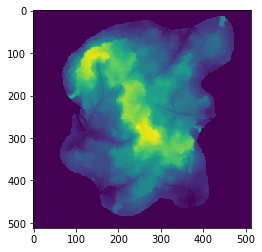

In [72]:
from tqdm.notebook import trange
s= datetime.datetime.now()
print("start:",s)
imgTest = np.zeros(imgray.shape,dtype='uint8')
maxT=s-s;
ijAtMaxT=None
for i in trange(imgray.shape[0], desc='1st loop'):
    for j in trange(imgray.shape[1], desc='2nd loop',leave=False):
        ts =  datetime.datetime.now()
        imgTest[i][j] = max(0,int(TerrainFunction((j,i))))
        te =  datetime.datetime.now()
        if (te-ts) > maxT:
            maxT= te-ts
            ijAtMaxT = (i,j)
plt.imshow(imgTest)
e=datetime.datetime.now()
print("End:",e)
print("render time: ", e -s )


In [73]:
immtt = np.array(imgTest)
normalizedImg = immtt.copy()
cv.normalize(immtt,  normalizedImg, 0, 255, cv.NORM_MINMAX)
cv.imwrite("island3out.png",normalizedImg)

True

In [74]:
endTime = datetime.datetime.now()
print("Total time: ", endTime -startTime )

Total time:  0:19:19.372959


In [75]:
np.argwhere(normalizedImg==255)

array([[272, 246],
       [273, 245],
       [273, 246],
       [273, 247],
       [274, 246],
       [274, 247],
       [275, 246],
       [275, 247],
       [275, 248],
       [276, 246],
       [276, 247],
       [276, 248],
       [277, 247],
       [277, 248],
       [285, 286],
       [285, 287],
       [285, 288],
       [286, 286],
       [286, 287],
       [286, 288],
       [287, 287],
       [295, 291],
       [296, 290],
       [296, 291],
       [296, 292],
       [297, 290],
       [297, 291],
       [297, 292]], dtype=int64)

In [76]:
maxT.asdads

AttributeError: 'datetime.timedelta' object has no attribute 'asdads'

In [ ]:


s= datetime.datetime.now()
print("start:",s)
#imgTest = np.zeros(imgray.shape,dtype='uint8')
 
print(TerrainFunction((326, 196)))
print(TerrainFunction((196, 326)))

e=datetime.datetime.now()
print("End:",e)
print("render time: ", e -s )

In [ ]:
s= datetime.datetime.now()
print("start:",s)
#imgTest = np.zeros(imgray.shape,dtype='uint8')

imgTest = [[int(TerrainFunction((j,i))) for j in range(128,160)] for i in range(128,160)]

plt.imshow(imgTest)
e=datetime.datetime.now()
print("End:",e)
print("render time: ", e -s )

In [ ]:
print(out)

In [ ]:


def TerrainFunction_(point):
    if imgray[point[1]][point[0]]==0:
        return 0
    ts = apkd.query_ball_point(point,radius) # within r distance of point

    
    #rs = setOfRivers # within r distance of point
    try:
        wts = [w(distance(point,allteepoints[t])) for t in ts]
    except:
        print(ts)
    hts = [ht(point,allteepoints[t]) for t in ts]
    #ht_ = height_b(hts,wts)
    #wt_ = np.sum(wts)/max(len(wts),1)
    
    #hr_ = height_b(hrs,wrs)
    ht_ = height_b(hts,wts)
    wt_ = wts[0]
    #for i in range(1,len(wts)):
    #    ht_ = (wt_*ht_+wts[i]*hts[i])/(wt_+wts[i])
    #    wt_ = (wt_+wts[i])/2
    
    #wr_ = np.sum(wrs)/max(len(wrs),1)
    wi=wt_
    hi=ht_
    ridx = imgvoronoi[point[1]][point[0]]-1
    if ridx==-1:
        return hi
    node = list(vor.point_region).index(ridx)
    rs  = [e for e in G.edges(node) if point_segment_distance_tuple(point,G.nodes[e[0]]['pos'],G.nodes[e[1]]['pos']) < radius ]+[e for e in G.in_edges(node) if point_segment_distance_tuple(point,G.nodes[e[0]]['pos'],G.nodes[e[1]]['pos']) < radius ]
    hrs = [hr_(point,e) for e in rs]
    wrs = [w(point_segment_distance_tuple(point,G.nodes[e[1]]['pos'],G.nodes[e[0]]['pos'])) for e in rs]
    for i in range(len(rs)): 
        hi= hi=(1-wrs[i])*hi+wrs[i]*hrs[i] 
        wi = (1-wrs[i])*wi+wrs[i]**2
    return hi

def height_b(h,w):
    try:
        ret = np.sum(np.multiply(h,w))/(np.sum(w))
        assert(ret>=0)
        assert(not np.isnan(ret))
        return ret
    except:
        return 0

scale = 100.0
octaves = 6
persistence = 0.5
lacunarity = 2.0
def ht(p,t):
    return czs[t] +pnoise2(p[0]/scale,p[1]/scale,octaves=octaves,persistence=persistence,lacunarity=lacunarity,repeatx=imgray.shape[0],repeaty=imgray.shape[1],base=0)*10
def hr_(p,r):
    n = np.subtract(G.nodes[r[0]]['pos'], G.nodes[r[1]]['pos'])
    nnorm = np.linalg.norm(n, 2)
    n = n/nnorm
    ret = np.dot(np.subtract(p,G.nodes[r[1]]['pos']), n)
    proj = ret/nnorm
    if proj >1 :
        proj=1
    if proj <0 :
        proj =0
    d=point_segment_distance_tuple(p,G.nodes[r[0]]['pos'],G.nodes[r[1]]['pos'])
    if d>rwidth:
        segma = rwidth**2
    else :
        segma = d**2
    return (1-proj)*G.nodes[r[1]]['elevation'] + G.nodes[r[0]]['elevation']*(proj)+segma




In [ ]:
def TerrainFunction(point):
    if imgray[point[1]][point[0]]==0:
        return 0
    ts = apkd.query_ball_point(point,radius) # within r distance of point

    
    #rs = setOfRivers # within r distance of point
    wts = [w(distance(point,allteepoints[t])) for t in ts]
    hts = [ht(point,allteepoints[t]) for t in ts]
    #ht_ = height_b(hts,wts)
    #wt_ = np.sum(wts)/max(len(wts),1)
    
    #hr_ = height_b(hrs,wrs)
    ht_ = height_b(hts,wts)
    wt_ = wts[0]
    #for i in range(1,len(wts)):
    #    ht_ = (wt_*ht_+wts[i]*hts[i])/(wt_+wts[i])
    #    wt_ = (wt_+wts[i])/2
    
    #wr_ = np.sum(wrs)/max(len(wrs),1)
    wi=wt_
    hi=ht_
    ridx = imgvoronoi[point[1]][point[0]]-1
    if ridx==-1:
        return hi
    node = list(vor.point_region).index(ridx)
    geomp = Point(point[0],point[1])
    #rs  = [e for e in G.edges(node) if point_segment_distance_tuple(point,G.nodes[e[0]]['pos'],G.nodes[e[1]]['pos']) < radius ]+[e for e in G.in_edges(node) if point_segment_distance_tuple(point,G.nodes[e[0]]['pos'],G.nodes[e[1]]['pos']) < radius ]
    local_rivers = rivers[node]
    #print(local_rivers)
    rividx = [geomp.distance(x) for x in local_rivers].index(min([geomp.distance(x) for x in local_rivers]))
    hr_ = hr(geomp,local_rivers[rividx])
    wr_ = w(geomp.distance(local_rivers[rividx]))
    
    hi=(1-wr_)*hi+wr_*hr_ 
    wi = (1-wr_)*wi+wr_**2